In [3]:
# Important standard packages 
import pandas as pd
import numpy as np

In [142]:
# Importing packages used in data pre-processing
import gensim
from gensim.utils import simple_preprocess, tokenize
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
import string 

In [173]:
data=pd.read_csv("FAOLEX_ALL.csv")
# print(data.keys())
# print(df.info())
# print(keywords[:5])

# Create simplified version of the dataframe by discarding irrelevant columns 
to_drop = ['Record Id', 
           'Record URL', 
           'Document URL', 
           'Title',
           'Original title',
           'Available website',
           'Abstract']

data.drop(to_drop, inplace=True, axis=1)

In [174]:
# Remove NaN values in the Countries/Territory and Keywords attributes 
data_no_nan = data.dropna(subset=["Country/Territory", "Keywords"])
print(f"This results in {len(data) - len(data_no_nan)} rows being dropped")

This results in 939 rows being dropped


In [213]:
data_kw = data_no_nan[["Country/Territory","Keywords"]]
data_kw['index'] = data_kw.index
keywords = data_kw

/var/folders/sb/klhtpy1n7jd649__g8r7xj300000gn/T/ipykernel_1489/1041940241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kw['index'] = data_kw.index


In [177]:
# Remove punctuation
def remove_punctuation(text):
    # signs = ";'-"
    signs = ";"
    #return "".join([i for i in text if i not in string.punctuation])
    return "".join([i for i in text if i not in signs])

In [178]:
# Data pre-processing 
def pre_process(text):
    text = remove_punctuation(text)
    text = text.lower()
    processed = list(tokenize(text))
    
    return processed

processed_kw = keywords["Keywords"].map(pre_process)

In [180]:
processed_kw[:10]

0      [maritime, zone, territorial, sea, sovereignty]
1    [territorial, sea, maritime, zone, eez, exclus...
2    [fishery, management, and, conservation, marin...
3    [basic, legislation, marine, fisheries, naviga...
4         [non, governmental, entity, internal, trade]
5           [harbour, navigation, harbour, navigation]
6    [maritime, zone, eez, exclusive, economic, zon...
7    [marine, fisheries, territorial, sea, maritime...
8    [basic, legislation, marine, fisheries, fisher...
9    [marine, fisheries, institution, fishery, mana...
Name: Keywords, dtype: object

# Top2Vec topic modelling

In [198]:
from top2vec import Top2Vec

# Create keywords as a list (after removal of NaN values which was done above)
keywords_top2vec = keywords.Keywords.values.tolist()

# Create the model
model = Top2Vec(documents=keywords_top2vec)


2023-06-05 21:44:57,411 - top2vec - INFO - Pre-processing documents for training
2023-06-05 21:45:09,878 - top2vec - INFO - Creating joint document/word embedding
2023-06-05 21:49:43,802 - top2vec - INFO - Creating lower dimension embedding of documents
2023-06-05 21:51:23,588 - top2vec - INFO - Finding dense areas of documents
2023-06-05 21:51:32,314 - top2vec - INFO - Finding topics


In [260]:
# Get the number of topics found in the corpus 
print(f"The Top2Vec model returns {model.get_num_topics()} topics")

# Get topic sizes 
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_nums)
print(topic_sizes)

The Top2Vec model returns 1156 topics
[   0    1    2 ... 1153 1154 1155]
[1394 1349 1259 ...   20   19   17]


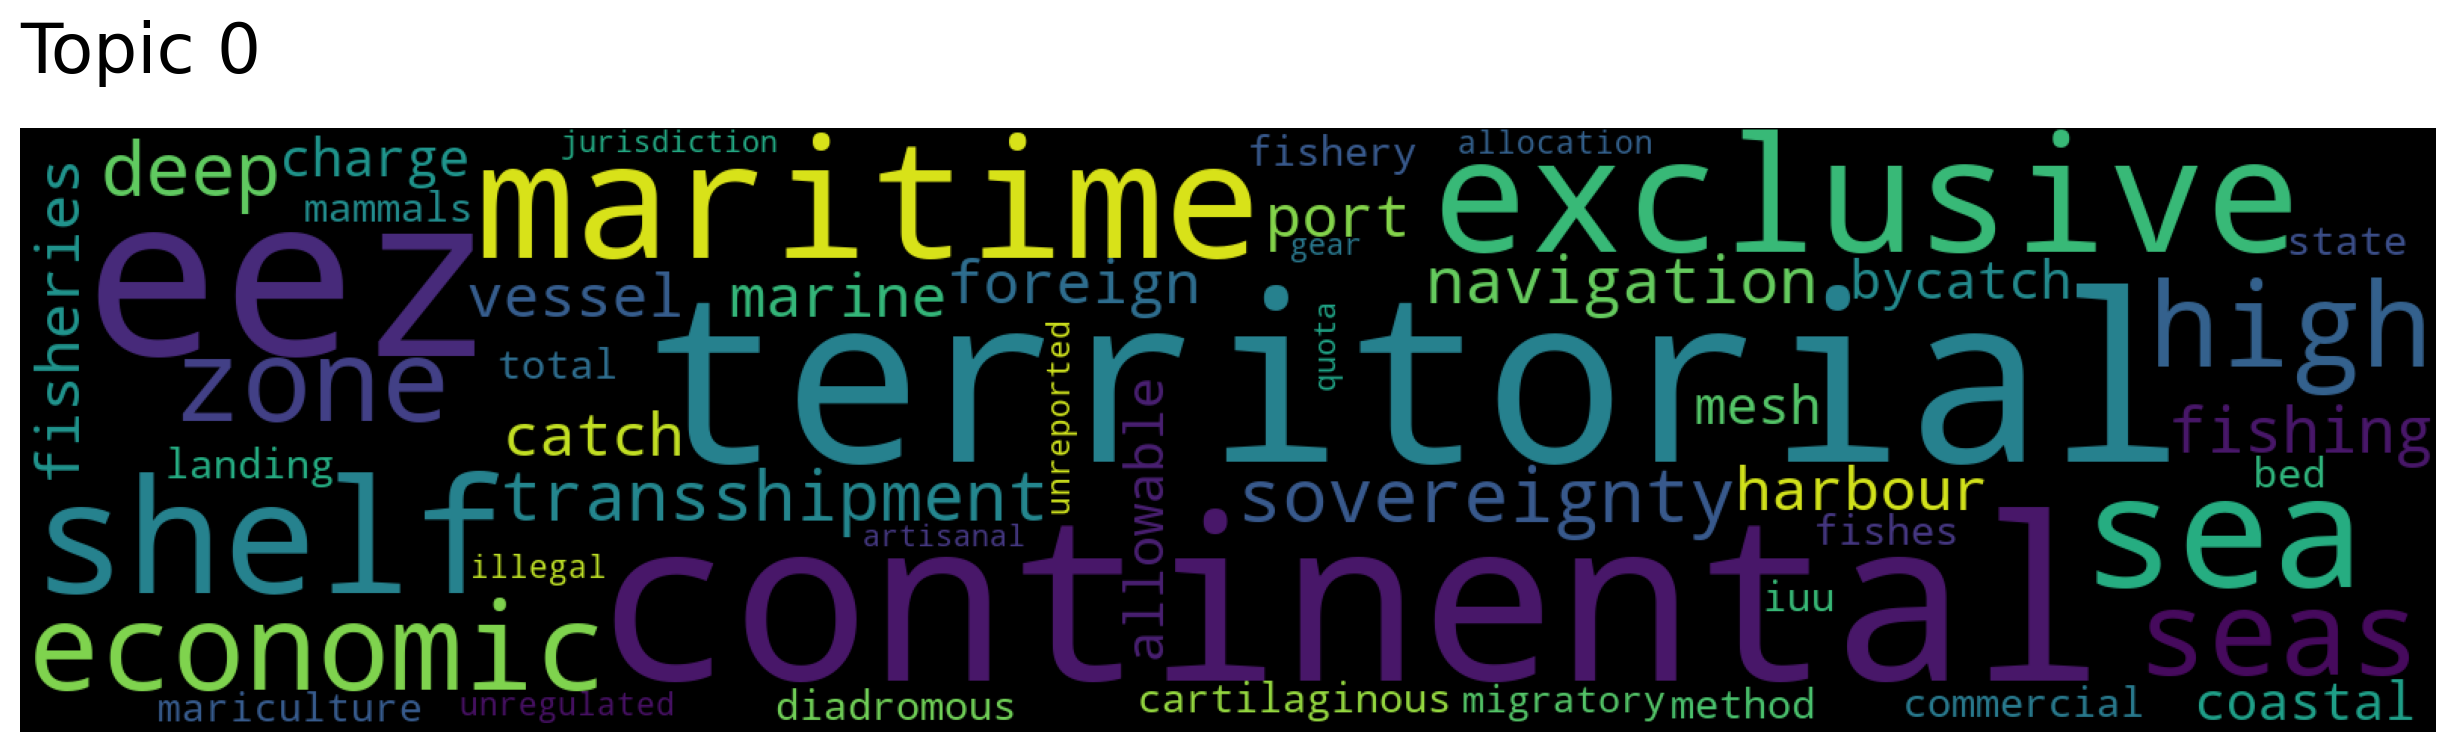

In [264]:
# Generate a wordcloud belonging to the topic with the largest number of documents
model.generate_topic_wordcloud(0)

# Co-occurence

In [277]:
# Create a list of countries 
all_countries = keywords["Country/Territory"].tolist()

In [278]:
countries_new=[]
for coun in all_countries:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            countries_new.append(c)
    else:
        countries_new.append(coun)

In [279]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(countries_new))):
    countries[country_x]=i
    i+=1

In [280]:
# Compute country x topic occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes()
country_topic_matrix = np.zeros((len(set(countries_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num])
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(all_countries[id].split(";"))>=2:
            for c in all_countries[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[all_countries[id]],num] +=1

In [281]:
# Relevant functions used in the next section
def square_rooted(x):
   return round(np.sqrt(sum([a*a for a in x])),3)
  
def cosine_similarity(x,y):
 numerator = sum(a*b for a,b in zip(x,y))
 denominator = square_rooted(x)*square_rooted(y)
 return round(numerator/float(denominator),3)

In [282]:
# Swap keys and values in countries dict
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

In [292]:
# Create country co-occurence matrix
def co_occurence(country_new, similarity):
    country_co_ocurrence = np.zeros((len(set(country_new)), len(set(country_new))))
    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_ocurrence[i,j] = np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1]
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_ocurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_ocurrence[i,j] = 1/(1+np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:]))
    return country_co_ocurrence

country_co_ocurrence = co_occurence(countries_new,"correlation")
np.shape(country_co_ocurrence)

(257, 257)

In [284]:
#Remove small islands

for i in range(len(set(countries_new))):
    if countries_new.count(countries_swap[i])<=20:
        country_co_ocurrence[i] = 0
        country_co_ocurrence[:,i] = 0

# Country networks

In [285]:
# Importing packages to create networks 
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt

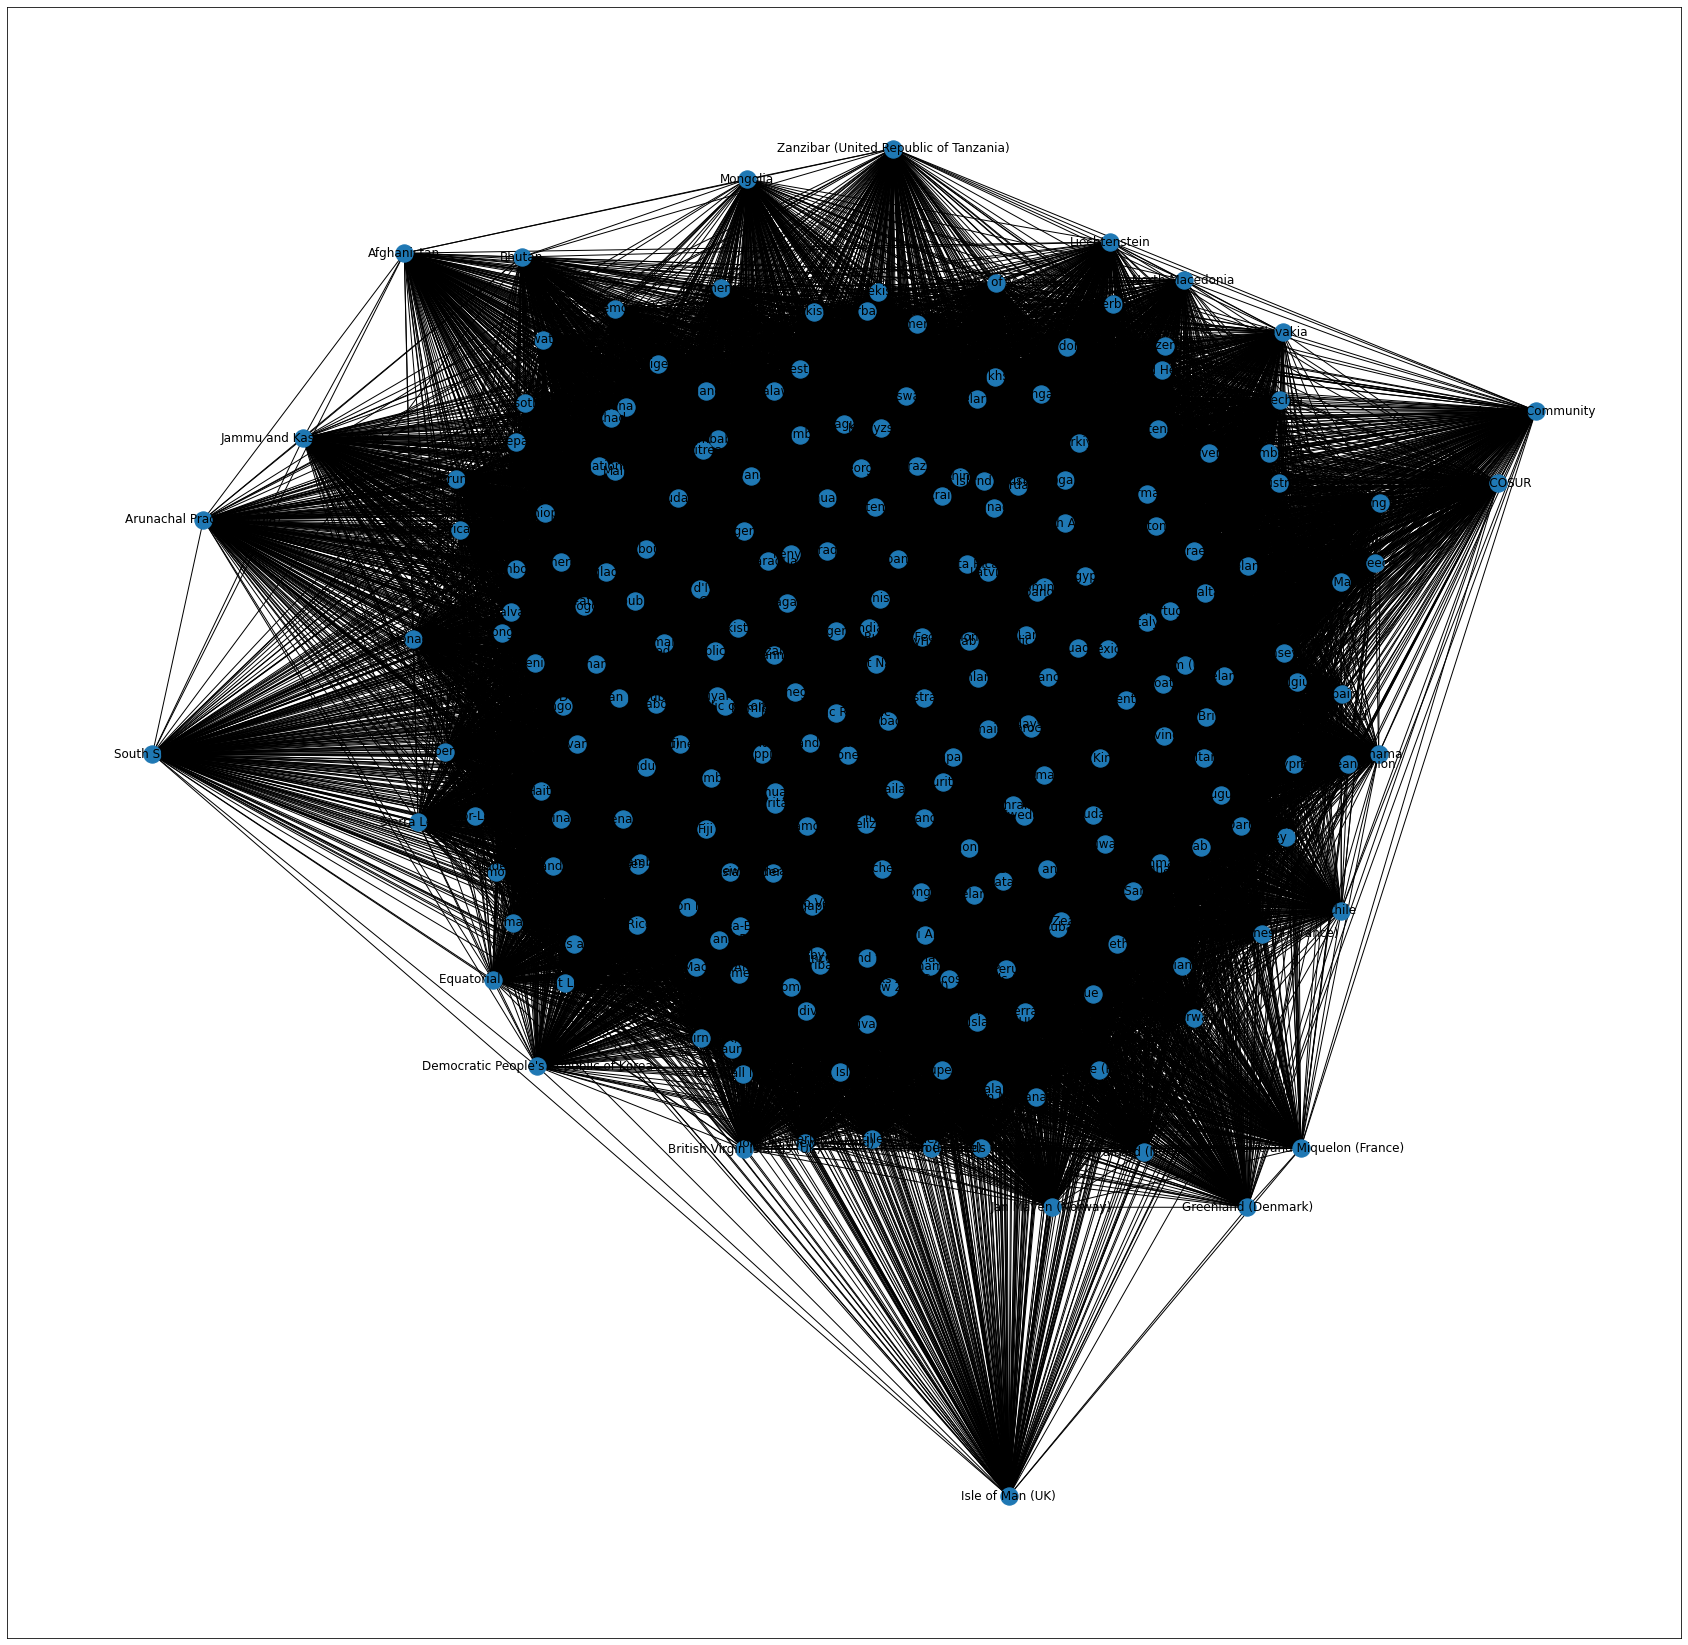

In [291]:
# Create graph
G = nx.Graph()

size = country_co_ocurrence.shape[0]

countries_swap_copy = countries_swap.copy()

G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_ocurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_ocurrence[i, j])

for i in range(size):
    if np.sum(country_co_ocurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)

plt.figure(figsize=(30, 30))
nx.draw_networkx(G, labels=countries_swap_copy,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)